# Gen2D

This notebook shows a simple model for clustering a 2D image into different components.
We recommend running it on a GPU, especially if N_ITER > 10 or N_BLOBS > 100.

In [ ]:
# type: ignore
from gen2d import animation
from gen2d import gibbs_updates
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from gen2d import model_simple_continuous

# import matplotlib.image as mpimg
from gen2d import utils
from IPython.display import display
from scipy import datasets

from genjax import ChoiceMapBuilder as C
from genjax import pretty
from genjax._src.core.generative.choice_map import ChoiceMap

pretty()

/Users/matuot/repos/mono/packages/gen2d/.pixi/envs/cpu/lib/python3.12/site-packages/genjax/_src/generative_functions/distributions/distribution.py:445: UserWarning: You should supply a name argument to exact_density
  warnings.warn("You should supply a name argument to exact_density")


## Hyperparameters

In [4]:
N_ITER = 10
RECORD = False  # All intermediate values in the MCMC chain
DEBUG = False
TRIVIAL = {  # Debugger: deactivate specific Gibbs moves
    "cluster_assignment": False,
    "xy_mean": False,
    "xy_sigma": False,
    "rgb_mean": False,
    "rgb_sigma": False,
    "mixture_weight": False,
}

image = datasets.face()  # Another example RGB image from scipy.datasets
H, W, _ = image.shape

# Load and convert image
# image = mpimg.imread("image (7).png") * 255
# H, W, _ = image.shape

N_BLOBS = 900  # needs to be a square number for now
A_XY = jnp.array([100.0, 100.0])
B_XY = jnp.array([10000.0, 10000.0])
MU_XY = jnp.array([H / 2, W / 2])
A_RGB = jnp.array([25.0, 25.0, 25.0])
B_RGB = jnp.array([450.0, 450.0, 450.0])
ALPHA: float = 1.0
SIGMA_XY = jnp.array(
    [
        H / jnp.sqrt(N_BLOBS),
        W / jnp.sqrt(N_BLOBS),
    ]
)  # so that the initial grid of blobs roughly covers the image
SIGMA_RGB = jnp.array([10.0, 10.0, 10.0])

(768, 1024)

## Model

### Testing to sample from model

In [3]:
hypers = model_simple_continuous.Hyperparams(
    a_xy=A_XY,
    b_xy=B_XY,
    mu_xy=MU_XY,
    a_rgb=A_RGB,
    b_rgb=B_RGB,
    alpha=ALPHA,
    sigma_xy=SIGMA_XY,
    sigma_rgb=SIGMA_RGB,
    n_blobs=N_BLOBS,
    H=H,
    W=W,
)

key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
jaxpr = jax.make_jaxpr(model_simple_continuous.model.simulate)(subkey, (hypers,))
print(jaxpr)
# tr = jax.jit(model_simple_continuous.model.simulate)(subkey, (hypers,))

{ lambda ; a:u32[2] b:f32[2] c:f32[2] d:f32[3] e:f32[2] f:f32[2] g:f32[3] h:f32[3]
    i:f32[]. let
    j:f32[900] = broadcast_in_dim[broadcast_dimensions=() shape=(900,)] 1.0
    _:f32[900] = div j 900.0
    _:f32[900,2] = broadcast_in_dim[broadcast_dimensions=() shape=(900, 2)] 1.0
    _:f32[900,2] = broadcast_in_dim[broadcast_dimensions=() shape=(900, 2)] 1.0
    _:f32[900,3] = broadcast_in_dim[broadcast_dimensions=() shape=(900, 3)] 1.0
    _:f32[900,3] = broadcast_in_dim[broadcast_dimensions=() shape=(900, 3)] 1.0
    k:i32[786432] = iota[dimension=0 dtype=int32 shape=(786432,) sharding=None] 
    l:key<fry>[] = random_wrap[impl=fry] a
    m:key<fry>[] = random_fold_in l 1
    n:u32[2] = random_unwrap m
    o:key<fry>[] = random_wrap[impl=fry] n
    p:key<fry>[786432] = random_split[shape=(786432,)] o
    q:u32[786432,2] = random_unwrap p
    _:f32[2] = broadcast_in_dim[broadcast_dimensions=() shape=(2,)] 1.0
    _:f32[2] = broadcast_in_dim[broadcast_dimensions=() shape=(2,)] 1.0


## Inference

We will do inference via exact block-Gibbs, using the fact that the model is defined using conjugate pairs.

### Gibbs updates

NEXT IMMEDIATE STEPS: 
- optimize GenJAX code

NEXT BIGGER STEPS:
- add hyperclustering to recover proto-objects
- conversion RGB -> Luminance + Chrominance (YCbCr) or HSL/HSV (closer to human. )
- do real time inference on videos
- model attention 
  - e.g. by bias number of Gaussians in a chosen region by artificially likelihood to matter more, e.g. duplicating points in that region
  - or do sub-inference on sub-image and merge back somehow
  - or allocate Gaussians per region, with bias on chosen region(s) for attention. maybe the hierarchical Gaussians could model attention!!
    - with this soft version of attention, this feels very general and we can bias the local likelihood for prey/predator detection.
- replace xy Gaussians by full covariance or different base blob (local model selection)
- coarse to fine inference compressed image -> original one.
- bridge blob of matter inference and goal inference/object tracking like hand-tracking.
- can we get Gen2D to do a better job than a conv net at clustering on MNIST
- we can do e.g. partial image reconstruction by masking out the green blobs

### Main inference loop

In [4]:
def id(key, trace):
    return trace


def initial_trace(key, image, hypers):
    # Image pre-processing
    H = hypers.H
    W = hypers.W
    y_coords, x_coords = jnp.indices((H, W))
    coords = jnp.stack([x_coords, y_coords], axis=-1)  # Create (x,y) pairs
    flattened_image = jnp.concatenate(
        (coords.reshape(H * W, 2), image.reshape(H * W, 3)), axis=1
    )
    xy, rgb = flattened_image[:, :2], flattened_image[:, 2:]

    n_blobs = hypers.n_blobs
    obs: ChoiceMap = C["likelihood_model", "xy"].set(xy) | C[
        "likelihood_model", "rgb"
    ].set(rgb)
    initial_weights = C["blob_model", "mixture_weight"].set(jnp.ones(n_blobs) / n_blobs)
    grid_of_xy_means = jnp.array(
        [
            [
                (i % jnp.array(jnp.sqrt(n_blobs), dtype=jnp.int32) + 0.5)
                * (W / jnp.sqrt(n_blobs)),
                (i // jnp.array(jnp.sqrt(n_blobs), dtype=jnp.int32) + 0.5)
                * (H / jnp.sqrt(n_blobs)),
            ]
            for i in range(n_blobs)
        ]
    )
    initial_cluster_xy_mean = C["blob_model", "xy_mean"].set(grid_of_xy_means)
    grid_of_points = jnp.argmin(
        jnp.sum((xy[:, None, :] - grid_of_xy_means[None, :, :]) ** 2, axis=2), axis=1
    )
    initial_cluster_assignment = C["likelihood_model", "blob_idx"].set(grid_of_points)
    constraints = (
        obs | initial_weights | initial_cluster_xy_mean | initial_cluster_assignment
    )

    # Sample an initial trace
    args = (hypers,)
    tr, _ = jax.jit(model_simple_continuous.model.importance)(key, constraints, args)

    return tr


def gibbs_fast(key, tracediff):
    def update(carry, _):
        key, tracediff = carry
        # Gibbs update on cluster assignments
        key, subkey = jax.random.split(key)
        if TRIVIAL["cluster_assignment"]:
            tracediff = id(key, tracediff)
        else:
            tracediff = jax.jit(gibbs_updates.update_cluster_assignment)(
                subkey, tracediff
            )

        # Gibbs update on xy means
        key, subkey = jax.random.split(key)
        if TRIVIAL["xy_mean"]:
            tracediff = id(key, tracediff)
        else:
            tracediff = jax.jit(gibbs_updates.update_xy_mean)(subkey, tracediff)

        # Gibbs update on xy variance
        key, subkey = jax.random.split(key)
        if TRIVIAL["xy_sigma"]:
            tracediff = id(key, tracediff)
        else:
            tracediff = jax.jit(gibbs_updates.update_xy_sigma)(subkey, tracediff)

        # Gibbs update on rgb means
        key, subkey = jax.random.split(key)
        if TRIVIAL["rgb_mean"]:
            tracediff = id(key, tracediff)
        else:
            tracediff = jax.jit(gibbs_updates.update_rgb_mean)(subkey, tracediff)

        # Gibbs update on rgb variance
        key, subkey = jax.random.split(key)
        if TRIVIAL["rgb_sigma"]:
            tracediff = id(key, tracediff)
        else:
            tracediff = jax.jit(gibbs_updates.update_rgb_sigma)(subkey, tracediff)

        # Gibbs update on mixture weights
        key, subkey = jax.random.split(key)
        if TRIVIAL["mixture_weight"]:
            tracediff = id(key, tracediff)
        else:
            tracediff = jax.jit(gibbs_updates.update_mixture_weight)(subkey, tracediff)

        if RECORD:
            return (key, tracediff), tracediff
        else:
            return (key, tracediff), None

    # Overall inference performs a fixed number of Gibbs sweeps
    scan_fn = jax.jit(lambda c, x: update(c, x))
    if RECORD:
        (_, tracediff), all_traces = jax.lax.scan(
            scan_fn, (key, tracediff), None, length=N_ITER
        )
        return tracediff, all_traces
    else:
        (_, tracediff), _ = jax.lax.scan(scan_fn, (key, tracediff), None, length=N_ITER)
        return tracediff


def infer(image, hypers):
    key = jax.random.key(32421)
    key, subkey = jax.random.split(key)
    tr = initial_trace(subkey, image, hypers)
    tracediff = utils.extract(tr)
    key, subkey = jax.random.split(key)
    if RECORD:
        tracediff, all_traces = gibbs_fast(subkey, tracediff)
        tr = utils.merge(key, tr, tracediff)
        all_posterior_xy_means = all_traces.chm["blob_model", "xy_mean"]
        all_posterior_xy_variances = all_traces.chm["blob_model", "sigma_xy"]
        all_posterior_rgb_means = all_traces.chm["blob_model", "rgb_mean"]
        all_posterior_rgb_variances = all_traces.chm["blob_model", "sigma_rgb"]
        all_posterior_weights = all_traces.chm["blob_model", "mixture_weight"]
        all_cluster_assignment = all_traces.chm["likelihood_model", "blob_idx"]
        return (
            all_posterior_xy_means,
            all_posterior_xy_variances,
            all_posterior_rgb_means,
            all_posterior_rgb_variances,
            all_posterior_weights,
            all_cluster_assignment,
            tr,
        )

    else:
        tracediff = gibbs_fast(subkey, tracediff)
        tr = utils.merge(key, tr, tracediff)
        return tr

In [5]:
if RECORD:
    (
        all_posterior_xy_means,
        all_posterior_xy_variances,
        all_posterior_rgb_means,
        all_posterior_rgb_variances,
        all_posterior_weights,
        all_cluster_assignment,
        tr,
    ) = jax.jit(infer)(image, hypers)
else:
    tr = jax.jit(infer)(image, hypers)
tr

StaticTrace(
  gen_fn=StaticGenerativeFunction(
    source=Closure(dyn_args=(), fn=<function model at 0x2d37289a0>),
  ),
  args=(
    Hyperparams(mu_xy=<jax.Array float32(2,) ≈4.5e+02 ±6.4e+01 [≥3.8e+02, ≤5.1e+02] nonzero:2>, sigma_xy=<jax.Array float32(2,) ≈3e+01 ±4.3 [≥2.6e+01, ≤3.4e+01] nonzero:2>, sigma_rgb=<jax.Array float32(3,) ≈1e+01 ±0.0 [≥1e+01, ≤1e+01] nonzero:3>, a_xy=<jax.Array float32(2,) ≈1e+02 ±0.0 [≥1e+02, ≤1e+02] nonzero:2>, b_xy=<jax.Array float32(2,) ≈1e+04 ±0.0 [≥1e+04, ≤1e+04] nonzero:2>, a_rgb=<jax.Array float32(3,) ≈2.5e+01 ±0.0 [≥2.5e+01, ≤2.5e+01] nonzero:3>, b_rgb=<jax.Array float32(3,) ≈4.5e+02 ±0.0 [≥4.5e+02, ≤4.5e+02] nonzero:3>, alpha=<jax.Array(1., dtype=float32, weak_type=True)>, n_blobs=900, H=768, W=1024),
  ),
  retval=None,
  subtraces={
    'blob_model': VmapTrace(
      gen_fn=Vmap(gen_fn=StaticGenerativeFunction(source=Closure(dyn_args=(), fn=<function blob_model at 0x2d3728860>)), in_axes=(0, None)),
      inner=StaticTrace(gen_fn=StaticGenerativeFunction(source=Closure(dyn_args=(), fn=<function blob_model at 0x2d3728860>)), args=(<jax.Array int32(900,) [≥0, ≤899] zero:1 nonzero:899>, Hyperparams(mu_xy=<jax.Array float32(900, 2) ≈4.5e+02 ±6.4e+01 [≥3.8e+02, ≤5.1e+02] nonzero:1_800>, sigma_xy=<jax.Array float32(900, 2) ≈3e+01 ±4.3 [≥2.6e+01, ≤3.4e+01] nonzero:1_800>, sigma_rgb=<jax.Array float32(900, 3) ≈1e+01 ±0.0 [≥1e+01, ≤1e+01] nonzero:2_700>, a_xy=<jax.Array float32(900, 2) ≈1e+02 ±0.0 [≥1e+02, ≤1e+02] nonzero:1_800>, b_xy=<jax.Array float32(900, 2) ≈1e+04 ±0.0 [≥1e+04, ≤1e+04] nonzero:1_800>, a_rgb=<jax.Array float32(900, 3) ≈2.5e+01 ±0.0 [≥2.5e+01, ≤2.5e+01] nonzero:2_700>, b_rgb=<jax.Array float32(900, 3) ≈4.5e+02 ±0.0 [≥4.5e+02, ≤4.5e+02] nonzero:2_700>, alpha=<jax.Array float32(900,) ≈1.0 ±0.0 [≥1.0, ≤1.0] nonzero:900>, n_blobs=900, H=768, W=1024)), retval=(<jax.Array float32(900, 2) ≈4.3e+02 ±2.6e+02 [≥1.4e+01, ≤1e+03] nonzero:1_800>, <jax.Array float32(900, 2) ≈2.7e+01 ±1.8e+01 [≥5.5, ≤1.5e+02] nonzero:1_800>, <jax.Array float32(900, 3) ≈1.2e+02 ±3.9e+01 [≥9.2, ≤2.4e+02] nonzero:2_700>, <jax.Array float32(900, 3) ≈5.1 ±2.5 [≥2.1, ≤2.1e+01] nonzero:2_700>, <jax.Array float32(900,) ≈0.0011 ±0.0014 [≥1.7e-09, ≤0.022] nonzero:900>), subtraces={'mixture_weight': DistributionTrace(gen_fn=genjax.unknown(), args=(<jax.Array float32(900,) ≈1.0 ±0.0 [≥1.0, ≤1.0] nonzero:900>, <jax.Array float32(900,) ≈1.0 ±0.0 [≥1.0, ≤1.0] nonzero:900>), value=<jax.Array float32(900,) ≈0.0011 ±0.0014 [≥1.7e-09, ≤0.022] nonzero:900>, score=<jax.Array float32(900,) ≈-0.0011 ±0.0014 [≥-0.022, ≤-4.8e-07] nonzero:900>), 'rgb_mean': DistributionTrace(gen_fn=genjax.normal(), args=(<jax.Array float32(900,) ≈1.3e+02 ±0.0 [≥1.3e+02, ≤1.3e+02] nonzero:900>, <jax.Array float32(900, 3) ≈1e+01 ±0.0 [≥1e+01, ≤1e+01] nonzero:2_700>), value=<jax.Array float32(900, 3) ≈1.2e+02 ±3.9e+01 [≥9.2, ≤2.4e+02] nonzero:2_700>, score=<jax.Array float32(900,) ≈-3.3e+01 ±2.9e+01 [≥-2.2e+02, ≤-9.7] nonzero:900>), 'sigma_rgb': DistributionTrace(gen_fn=genjax.inverse_gamma(), args=(<jax.Array float32(900, 3) ≈2.5e+01 ±0.0 [≥2.5e+01, ≤2.5e+01] nonzero:2_700>, <jax.Array float32(900, 3) ≈4.5e+02 ±0.0 [≥4.5e+02, ≤4.5e+02] nonzero:2_700>), value=<jax.Array float32(900, 3) ≈5.1 ±2.5 [≥2.1, ≤2.1e+01] nonzero:2_700>, score=<jax.Array float32(900,) ≈-1.4e+02 ±7.4e+01 [≥-3.4e+02, ≤-8.3] nonzero:900>), 'sigma_xy': DistributionTrace(gen_fn=genjax.inverse_gamma(), args=(<jax.Array float32(900, 2) ≈1e+02 ±0.0 [≥1e+02, ≤1e+02] nonzero:1_800>, <jax.Array float32(900, 2) ≈1e+04 ±0.0 [≥1e+04, ≤1e+04] nonzero:1_800>), value=<jax.Array float32(900, 2) ≈2.7e+01 ±1.8e+01 [≥5.5, ≤1.5e+02] nonzero:1_800>, score=<jax.Array float32(900,) ≈-5.1e+02 ±3.5e+02 [≥-1.8e+03, ≤-8.7] nonzero:900>), 'xy_mean': DistributionTrace(gen_fn=genjax.normal(), args=(<jax.Array float32(900, 2) ≈4.5e+02 ±6.4e+01 [≥3.8e+02, ≤5.1e+02] nonzero:1_800>, <jax.Array float32(900, 2) ≈3e+01 ±4.3 [≥2.6e+01, ≤3.4e+01] nonzero:1_800>), value=<jax.Array float32(900, 2) ≈4.3e+02 ±2.6e+02 [≥1.4

### Visualizating Inference

In [6]:
if RECORD:
    visualization = animation.create_cluster_visualization(
        all_posterior_xy_means,
        all_posterior_xy_variances,
        all_posterior_weights,
        all_posterior_rgb_means,
        all_cluster_assignment,
        image=image,
        num_frames=15,
        pixel_sampling=10,  # Sample every 10th pixel
        confidence_factor=3.0,  # Scale factor for ellipses
        min_weight=0.01,  # Minimum weight threshold for showing clusters
    )

    display(visualization)

### Image reconstruction

TODO: write a visualization of the intermediate steps, and maybe generate more points at each step for better rendering.

In [7]:
sigma_xy, sigma_rgb, xy_mean, rgb_mean, mixture_weight = utils.extract_blob_params(tr)
obs = utils.create_blob_observations(
    sigma_xy, sigma_rgb, xy_mean, rgb_mean, mixture_weight
)

key, subkey = jax.random.split(key)
args = (hypers,)
new_tr, _ = jax.jit(model_simple_continuous.model.importance)(subkey, obs, args)
new_tr

StaticTrace(
  gen_fn=StaticGenerativeFunction(
    source=Closure(dyn_args=(), fn=<function model at 0x2d37289a0>),
  ),
  args=(
    Hyperparams(mu_xy=<jax.Array float32(2,) ≈4.5e+02 ±6.4e+01 [≥3.8e+02, ≤5.1e+02] nonzero:2>, sigma_xy=<jax.Array float32(2,) ≈3e+01 ±4.3 [≥2.6e+01, ≤3.4e+01] nonzero:2>, sigma_rgb=<jax.Array float32(3,) ≈1e+01 ±0.0 [≥1e+01, ≤1e+01] nonzero:3>, a_xy=<jax.Array float32(2,) ≈1e+02 ±0.0 [≥1e+02, ≤1e+02] nonzero:2>, b_xy=<jax.Array float32(2,) ≈1e+04 ±0.0 [≥1e+04, ≤1e+04] nonzero:2>, a_rgb=<jax.Array float32(3,) ≈2.5e+01 ±0.0 [≥2.5e+01, ≤2.5e+01] nonzero:3>, b_rgb=<jax.Array float32(3,) ≈4.5e+02 ±0.0 [≥4.5e+02, ≤4.5e+02] nonzero:3>, alpha=<jax.Array(1., dtype=float32, weak_type=True)>, n_blobs=900, H=768, W=1024),
  ),
  retval=None,
  subtraces={
    'blob_model': VmapTrace(
      gen_fn=Vmap(gen_fn=StaticGenerativeFunction(source=Closure(dyn_args=(), fn=<function blob_model at 0x2d3728860>)), in_axes=(0, None)),
      inner=StaticTrace(gen_fn=StaticGenerativeFunction(source=Closure(dyn_args=(), fn=<function blob_model at 0x2d3728860>)), args=(<jax.Array int32(900,) [≥0, ≤899] zero:1 nonzero:899>, Hyperparams(mu_xy=<jax.Array float32(900, 2) ≈4.5e+02 ±6.4e+01 [≥3.8e+02, ≤5.1e+02] nonzero:1_800>, sigma_xy=<jax.Array float32(900, 2) ≈3e+01 ±4.3 [≥2.6e+01, ≤3.4e+01] nonzero:1_800>, sigma_rgb=<jax.Array float32(900, 3) ≈1e+01 ±0.0 [≥1e+01, ≤1e+01] nonzero:2_700>, a_xy=<jax.Array float32(900, 2) ≈1e+02 ±0.0 [≥1e+02, ≤1e+02] nonzero:1_800>, b_xy=<jax.Array float32(900, 2) ≈1e+04 ±0.0 [≥1e+04, ≤1e+04] nonzero:1_800>, a_rgb=<jax.Array float32(900, 3) ≈2.5e+01 ±0.0 [≥2.5e+01, ≤2.5e+01] nonzero:2_700>, b_rgb=<jax.Array float32(900, 3) ≈4.5e+02 ±0.0 [≥4.5e+02, ≤4.5e+02] nonzero:2_700>, alpha=<jax.Array float32(900,) ≈1.0 ±0.0 [≥1.0, ≤1.0] nonzero:900>, n_blobs=900, H=768, W=1024)), retval=(<jax.Array float32(900, 2) ≈4.3e+02 ±2.6e+02 [≥1.4e+01, ≤1e+03] nonzero:1_800>, <jax.Array float32(900, 2) ≈2.7e+01 ±1.8e+01 [≥5.5, ≤1.5e+02] nonzero:1_800>, <jax.Array float32(900, 3) ≈1.2e+02 ±3.9e+01 [≥9.2, ≤2.4e+02] nonzero:2_700>, <jax.Array float32(900, 3) ≈5.1 ±2.5 [≥2.1, ≤2.1e+01] nonzero:2_700>, <jax.Array float32(900,) ≈0.0011 ±0.0014 [≥1.7e-09, ≤0.022] nonzero:900>), subtraces={'mixture_weight': DistributionTrace(gen_fn=genjax.unknown(), args=(<jax.Array float32(900,) ≈1.0 ±0.0 [≥1.0, ≤1.0] nonzero:900>, <jax.Array float32(900,) ≈1.0 ±0.0 [≥1.0, ≤1.0] nonzero:900>), value=<jax.Array float32(900,) ≈0.0011 ±0.0014 [≥1.7e-09, ≤0.022] nonzero:900>, score=<jax.Array float32(900,) ≈-0.0011 ±0.0014 [≥-0.022, ≤-4.8e-07] nonzero:900>), 'rgb_mean': DistributionTrace(gen_fn=genjax.normal(), args=(<jax.Array float32(900,) ≈1.3e+02 ±0.0 [≥1.3e+02, ≤1.3e+02] nonzero:900>, <jax.Array float32(900, 3) ≈1e+01 ±0.0 [≥1e+01, ≤1e+01] nonzero:2_700>), value=<jax.Array float32(900, 3) ≈1.2e+02 ±3.9e+01 [≥9.2, ≤2.4e+02] nonzero:2_700>, score=<jax.Array float32(900,) ≈-3.3e+01 ±2.9e+01 [≥-2.2e+02, ≤-9.7] nonzero:900>), 'sigma_rgb': DistributionTrace(gen_fn=genjax.inverse_gamma(), args=(<jax.Array float32(900, 3) ≈2.5e+01 ±0.0 [≥2.5e+01, ≤2.5e+01] nonzero:2_700>, <jax.Array float32(900, 3) ≈4.5e+02 ±0.0 [≥4.5e+02, ≤4.5e+02] nonzero:2_700>), value=<jax.Array float32(900, 3) ≈5.1 ±2.5 [≥2.1, ≤2.1e+01] nonzero:2_700>, score=<jax.Array float32(900,) ≈-1.4e+02 ±7.4e+01 [≥-3.4e+02, ≤-8.3] nonzero:900>), 'sigma_xy': DistributionTrace(gen_fn=genjax.inverse_gamma(), args=(<jax.Array float32(900, 2) ≈1e+02 ±0.0 [≥1e+02, ≤1e+02] nonzero:1_800>, <jax.Array float32(900, 2) ≈1e+04 ±0.0 [≥1e+04, ≤1e+04] nonzero:1_800>), value=<jax.Array float32(900, 2) ≈2.7e+01 ±1.8e+01 [≥5.5, ≤1.5e+02] nonzero:1_800>, score=<jax.Array float32(900,) ≈-5.1e+02 ±3.5e+02 [≥-1.8e+03, ≤-8.7] nonzero:900>), 'xy_mean': DistributionTrace(gen_fn=genjax.normal(), args=(<jax.Array float32(900, 2) ≈4.5e+02 ±6.4e+01 [≥3.8e+02, ≤5.1e+02] nonzero:1_800>, <jax.Array float32(900, 2) ≈3e+01 ±4.3 [≥2.6e+01, ≤3.4e+01] nonzero:1_800>), value=<jax.Array float32(900, 2) ≈4.3e+02 ±2.6e+02 [≥1.4

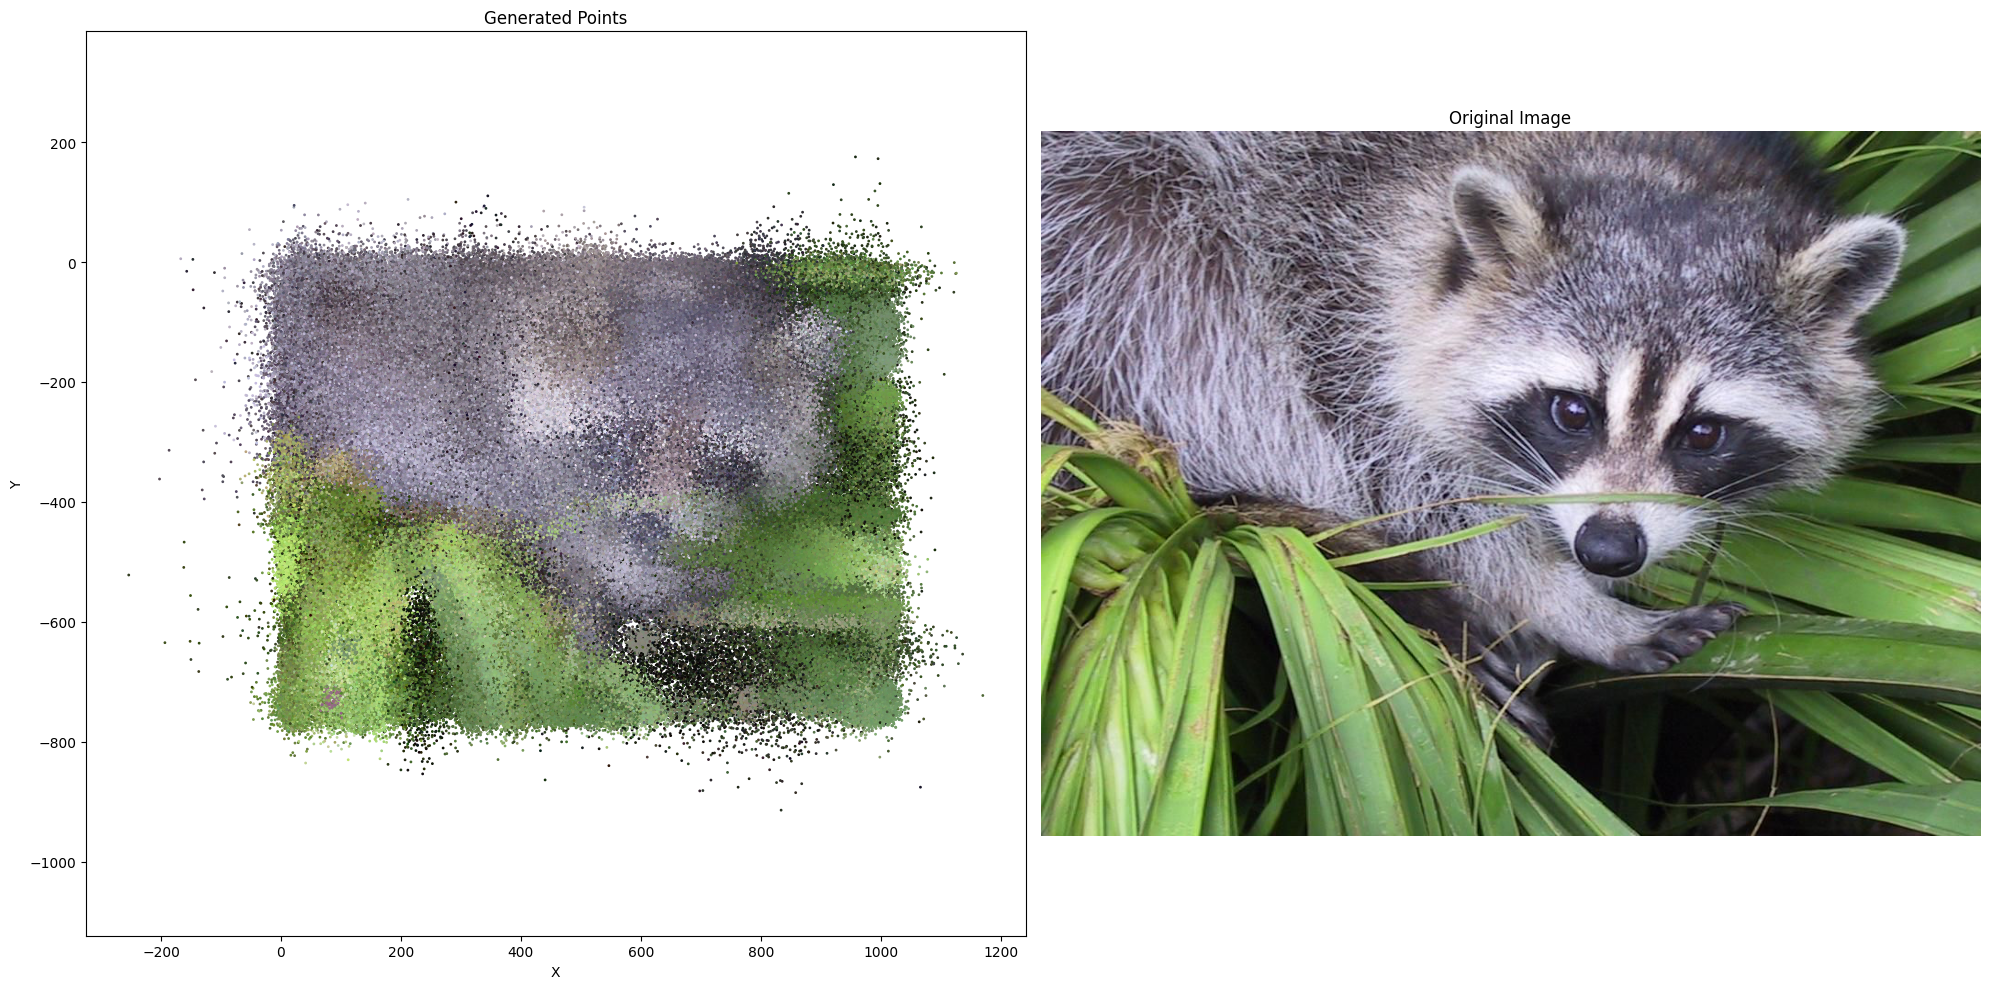

In [8]:
def plot_reconstruction_comparison(trace, original_image):
    """Plot generated points from model trace alongside original image.

    Args:
        trace: Model execution trace containing generated points
        original_image: Original input image to compare against

    Returns:
        None. Displays matplotlib figure.
    """
    xy = trace.get_choices()["likelihood_model", "xy"]
    rgb = jnp.clip(trace.get_choices()["likelihood_model", "rgb"], 0, 255)

    # Create a figure with two subplots side by side
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Generated points
    ax1.scatter(
        xy[:, 0], -xy[:, 1], c=rgb / 255.0, s=1
    )  # Negate y coordinates to flip vertically
    ax1.axis("equal")
    ax1.set_title("Generated Points")
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")

    # Original image
    ax2.imshow(original_image.astype(jnp.uint8))
    ax2.axis("off")
    ax2.set_title("Original Image")

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()


plot_reconstruction_comparison(new_tr, image)